<a href="https://colab.research.google.com/github/derek-byte/Melanoma_Deep_Learning/blob/main/MELANOMA_DETECTION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import os
from keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

In [2]:
train_dir='/content/drive/MyDrive/Melanoma_Dataset/train'
Labels = ['Melanoma', 'NotMelanoma']
print ("class : ") 
for i in range(len(Labels)): 
    print (i, end = " ") 
    print (Labels[i])

class : 
0 Melanoma
1 NotMelanoma


In [3]:
module_selection = ("mobilenet_v2", 224, 1280) 
handle_base, pixels, FV_SIZE = module_selection
MODULE_HANDLE ="https://tfhub.dev/google/tf2-preview/{}/feature_vector/2".format(handle_base)
IMAGE_SIZE = (pixels, pixels)
BATCH_SIZE = 16 

In [ ]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
      rescale = 1./255,
      rotation_range=40,
      horizontal_flip=True,
      width_shift_range=0.2, 
      height_shift_range=0.2,
      shear_range=0.2, 
      zoom_range=0.2,
      fill_mode='nearest',
      validation_split=0.3)
  
train_generator = train_datagen.flow_from_directory(
    train_dir, 
    subset="training", 
    shuffle=True, 
    seed=42,
    color_mode="rgb", 
    class_mode="categorical",
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE)
validation_generator = train_datagen.flow_from_directory(
    train_dir, 
    shuffle=False, 
    seed=42,
    color_mode="rgb", 
    class_mode="categorical",
    subset="validation",
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE)

In [ ]:
feature_extractor = hub.KerasLayer(MODULE_HANDLE,input_shape=IMAGE_SIZE+(3,), output_shape=[FV_SIZE])
do_fine_tuning = False 
if do_fine_tuning:
  feature_extractor.trainable = True
  for layer in base_model.layers[-30:]:
    layer.trainable =True
  
else:
  feature_extractor.trainable = False
print("Building model with", MODULE_HANDLE)
model = tf.keras.Sequential([
    feature_extractor,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(train_generator.num_classes, activation='softmax',
                           kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])
model.summary()

In [9]:
LEARNING_RATE = 0.001 
model.compile(
   optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE), 
   loss='categorical_crossentropy',
   metrics=['accuracy'])

In [ ]:
EPOCHS=15
history = model.fit(
        train_generator,
        # steps_per_epoch = train_generator.samples//train_generator.batch_size,
        steps_per_epoch = 10,
        epochs=EPOCHS,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples//validation_generator.batch_size)

Checking Performance

In [ ]:
import matplotlib.pylab as plt
import numpy as np

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.show()

Test At Random

In [ ]:
import random
import cv2
def upload(filename):
    img = cv2.imread(os.path.join(train_dir, filename))
    img = cv2.resize(img, (224, 224) )
    img = img /255
    return img
def pre_result(image):
    x = model.predict(np.asarray([img]))[0]
    classx = np.argmax(x)
    return {Labels[classx]: x[classx]}
images = random.sample(validation_generator.filenames, 16)
for idx, filename in enumerate(images):
    img = upload(filename)
    prediction = pre_result(img)
    print("SOURCE: class: %s, file: %s" % (os.path.split(filename)[0], filename))
    print("class: %s, Confidence: %f" % (list(prediction.keys())[0], list(prediction.values())[0]))
    plt.imshow(img)
    plt.figure(idx)    
    plt.show()

Confusion Matrix

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

predictions1 = model.predict(validation_generator, steps=len(validation_generator))
y = np.argmax(predictions1, axis=1)

print('Classification Report')
cr = classification_report(y_true=validation_generator.classes, y_pred=y, target_names=validation_generator.class_indices)
print(cr)

evaluates = model.evaluate(validation_generator)
print(evaluates)

Classification Report
              precision    recall  f1-score   support

    Melanoma       0.97      0.99      0.98      1521
 NotMelanoma       0.99      0.97      0.98      1602

    accuracy                           0.98      3123
   macro avg       0.98      0.98      0.98      3123
weighted avg       0.98      0.98      0.98      3123

196/196 [==============================] - 94s 477ms/step - loss: 0.0684 - accuracy: 0.9808
[0.06840399652719498, 0.9807876944541931]


Confusion Matrix


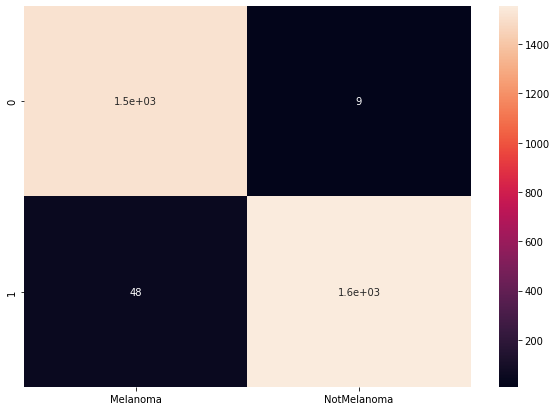

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sn
print('Confusion Matrix')
cm = confusion_matrix(validation_generator.classes, y)
df = pd.DataFrame(cm, columns=validation_generator.class_indices)
plt.figure(figsize=(10,7))
sn.heatmap(df, annot=True)

Export as Saved Model and Convert to TFLite

In [ ]:
import time
t = time.time()
export_path = "/content/drive/MyDrive/Melanoma_Models{}".format(int(t))
tf.keras.models.save_model(model, export_path)
export_path

In [14]:
# Now confirm that we can reload it, and it still gives the same results
path = "/content/drive/MyDrive/Melanoma_Models_Good_Copy"
reloaded = tf.keras.models.load_model(path, custom_objects={'KerasLayer':hub.KerasLayer})
def predict_reload(image):
    probabilities = reloaded.predict(np.asarray([img]))[0]
    class_idx = np.argmax(probabilities)
    return {Labels[class_idx]: probabilities[class_idx]}

In [ ]:
for idx, filename in enumerate(random.sample(validation_generator.filenames, 2)):
    print("SOURCE: class: %s, file: %s" % (os.path.split(filename)[0], filename))
    img = upload(filename)
    prediction = predict_reload(img)
    print("PREDICTED: class: %s, confidence: %f" % (list(prediction.keys())[0], list(prediction.values())[0]))
    plt.imshow(img)
    plt.figure(idx)    
    plt.show()

In [ ]:
# convert the model to TFLite
!mkdir "tflite_models"
TFLITE_MODEL = "tflite_models/model.tflite"
# Get the concrete function from the Keras model.
run_model = tf.function(lambda x : reloaded(x))
# Save the concrete function.
concrete_func = run_model.get_concrete_function(
    tf.TensorSpec(model.inputs[0].shape, model.inputs[0].dtype)
)
# Convert the model to standard TensorFlow Lite model
converter = tf.lite.TFLiteConverter.from_concrete_functions([concrete_func])
converted_tflite_model = converter.convert()
open(TFLITE_MODEL, "wb").write(converted_tflite_model)

Flask Web App

In [8]:
!pip install flask-ngrok
# # !pip install flask-bootstrap

In [ ]:
!curl -s https://ngrok-agent.s3.amazonaws.com/ngrok.asc | sudo tee /etc/apt/trusted.gpg.d/ngrok.asc >/dev/null && echo "deb https://ngrok-agent.s3.amazonaws.com buster main" | sudo tee /etc/apt/sources.list.d/ngrok.list && sudo apt update && sudo apt install ngrok   

In [11]:
!ngrok authtoken 26myWhdKL3FJvSiQfVOLduesolf_3iGZpQGynAH14orGSyv9z

Authtoken saved to configuration file: /root/.ngrok2/ngrok.yml


In [ ]:
from flask_ngrok import run_with_ngrok
from flask import Flask, render_template, request, flash, url_for, redirect
import urllib.request
from werkzeug.utils import secure_filename

app = Flask(__name__)
run_with_ngrok(app)   

@app.route('/')
def home():
    return render_template('index.html')
  
@app.route("/", methods=["POST"])
def upload_image():
  # if request.method == "POST":
  #   inputted_img = request.form["image"]
  #   print("image")
  #   return render_template('index.html')
  # else:
  #   return render_template('index.html')
  file = request.files['image']
  if file not in request.files:
        flash('No file part')
        return redirect(request.url)

  if file.filename == '':
      flash('No image selected for uploading')
      return redirect(request.url)
  if file and allowed_file(file.filename):
      filename = secure_filename(file.filename)
      file.save(os.path.join(app.config['UPLOAD_FOLDER'], filename))
      #print('upload_image filename: ' + filename)
      flash('Image successfully uploaded and displayed below')
      return render_template('index.html', filename=filename)
  else:
      flash('Allowed image types are - png, jpg, jpeg, gif')
      return redirect(request.url)

@app.route('/display/<filename>')
def display_image(filename):
    #print('display_image filename: ' + filename)
    return redirect(url_for('static', filename='uploads/' + filename), code=301)
    
app.run()

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)


 * Running on http://ad08-35-189-172-105.ngrok.io
 * Traffic stats available on http://127.0.0.1:4040


127.0.0.1 - - [30/Mar/2022 03:14:11] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [30/Mar/2022 03:14:12] "GET /static/styles.css HTTP/1.1" 200 -
127.0.0.1 - - [30/Mar/2022 03:14:12] "GET /display/ HTTP/1.1" 404 -
127.0.0.1 - - [30/Mar/2022 03:14:12] "GET /favicon.ico HTTP/1.1" 404 -
[2022-03-30 03:14:13,930] ERROR in app: Exception on / [POST]
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/flask/app.py", line 2447, in wsgi_app
    response = self.full_dispatch_request()
  File "/usr/local/lib/python3.7/dist-packages/flask/app.py", line 1952, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/usr/local/lib/python3.7/dist-packages/flask/app.py", line 1821, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/usr/local/lib/python3.7/dist-packages/flask/_compat.py", line 39, in reraise
    raise value
  File "/usr/local/lib/python3.7/dist-packages/flask/app.py", line 1950, in full_dispatch_request
    rv = self.dispatch_req